# 模型构造

In [2]:
import torch
from torch import nn
from torch.nn import functional as F


In [4]:
# nn.Sequential定义了一种特俗的module
net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
net(X)

tensor([[-0.2354,  0.3206,  0.0316, -0.0423, -0.0785,  0.1997, -0.0862, -0.1088,
         -0.0779,  0.0026],
        [-0.1861,  0.3897, -0.0467, -0.0831, -0.1425,  0.2447, -0.0674, -0.0216,
         -0.1271,  0.0709]], grad_fn=<AddmmBackward>)

In [5]:
class MLP(nn.Module):
    def __init__(self):
        # super()调用nn.Module里的一些参数
        super().__init__()
        # 两个全连接层
        self.hidden = nn.Linear(20, 256)
        self.out = nn.Linear(256, 10)
        
    # 前向函数
    def forward(self, X):
        return self.out(F.relu(self.hidden(X)))

In [6]:
net = MLP()
net(X)

tensor([[-0.2473,  0.0286,  0.2627, -0.2708,  0.0213, -0.1553,  0.0470, -0.2841,
          0.1739, -0.1278],
        [-0.3080, -0.0180,  0.1839, -0.0843,  0.0595, -0.1372,  0.1206, -0.0999,
          0.1476, -0.0988]], grad_fn=<AddmmBackward>)

## 顺序块

In [7]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        # block代表层
        for block in args:
            self._modules[block] = block
    
    def forward(self, X):
        for block in self._modules.values():
            X = block(X)
        return X

net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[ 0.2715, -0.0832, -0.0688,  0.1327,  0.0118, -0.3006,  0.0327, -0.1013,
          0.1114,  0.2134],
        [ 0.1647, -0.0942, -0.0755,  0.1673, -0.0920, -0.2964,  0.0182,  0.0051,
          0.1039,  0.1259]], grad_fn=<AddmmBackward>)

In [9]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)
    
    def forward(self, X):
        X = self.linear(X)
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        X = self.linear(X)
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

net = FixedHiddenMLP()
net(X)

tensor(0.1731, grad_fn=<SumBackward0>)

## 混合搭配各种组合块的方法

In [10]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),
                                nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)
        
    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)

tensor(0.0797, grad_fn=<SumBackward0>)

# 参数管理
假设模型已经定义好，那么如何访问模型参数？

In [13]:
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
net

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
)

In [15]:
X = torch.rand(size=(2, 4))
X

tensor([[0.7940, 0.8092, 0.9839, 0.3327],
        [0.5144, 0.3940, 0.6238, 0.5871]])

In [16]:
net(X)

tensor([[0.3920],
        [0.3169]], grad_fn=<AddmmBackward>)

## 查看最后一个输入层的输入参数

In [17]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[ 0.2439,  0.0843, -0.2259, -0.3376,  0.2417,  0.2979,  0.2647, -0.0374]])), ('bias', tensor([0.2315]))])


## 目标参数

In [18]:
print(type(net[2].bias))

<class 'torch.nn.parameter.Parameter'>


是一个torch.nn.parameter类型的参数，既然是数就可以打印

In [21]:
print(net[0].bias)

Parameter containing:
tensor([ 0.2279,  0.4963,  0.3827, -0.4798, -0.4052, -0.0656,  0.1719, -0.3951],
       requires_grad=True)


In [22]:
print(net[1].bias)

AttributeError: 'ReLU' object has no attribute 'bias'

In [23]:
print(net[2].bias)

Parameter containing:
tensor([0.2315], requires_grad=True)


In [25]:
print(net[2].weight.data)

tensor([[ 0.2439,  0.0843, -0.2259, -0.3376,  0.2417,  0.2979,  0.2647, -0.0374]])


In [26]:
print(net[2].bias.data)

tensor([0.2315])


In [28]:
# 访问梯度（梯度为零是因为还没有开始做计算）
net[0].weight.grad == None

True

## 一次性访问所有参数

In [39]:
for name, param in net[0].named_parameters():
    print('1:', name, param)
    print('2:', name, param.shape)

1: weight Parameter containing:
tensor([[ 0.2798, -0.1931, -0.3758, -0.2138],
        [-0.2413, -0.2020,  0.0657,  0.4402],
        [-0.3319,  0.3743, -0.4766,  0.4368],
        [-0.3449, -0.3569, -0.1191, -0.2277],
        [ 0.3785, -0.3592,  0.1787,  0.3010],
        [ 0.1802,  0.1929,  0.2127,  0.2129],
        [-0.1364, -0.1889,  0.0900, -0.4354],
        [ 0.3015, -0.1022,  0.0232, -0.2889]], requires_grad=True)
2: weight torch.Size([8, 4])
1: bias Parameter containing:
tensor([ 0.2279,  0.4963,  0.3827, -0.4798, -0.4052, -0.0656,  0.1719, -0.3951],
       requires_grad=True)
2: bias torch.Size([8])


即：

In [40]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))


In [45]:
# relu是没有层的
print(*[(name, param.shape) for name, param in net.named_parameters()])

('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


In [51]:
net.state_dict()['2.weight'].data

tensor([[ 0.2439,  0.0843, -0.2259, -0.3376,  0.2417,  0.2979,  0.2647, -0.0374]])

## 从嵌套块中收集参数

当网络中有嵌套时，收集参数的方法

In [66]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[-0.3916],
        [-0.3915]], grad_fn=<AddmmBackward>)

In [67]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


## 参数初始化
深度学习框架提供默认随机初始化。然而，我们经常希望根据其他规则初始化权重。深度学习框架提供了最常用的规则，也允许创建自定义初始化方法。

### 内置初始化
调用内置的初始化器，下面的代码将所有权重参数初始化为标准差为0.01的高斯随机变量，且将偏置参数设置为0

In [70]:
def init_normal(m):
    if type(m) == nn.Linear:
        # Fills self tensor with elements samples from the normal distribution parameterized by mean and std.
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)
net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0012, -0.0031, -0.0116, -0.0088]), tensor(0.))

In [69]:
# 我们还可以将所有参数初始化为给定的常数（比如1）
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

我们还可以对某些块应用不同的初始化方法。例如，下面我们使用Xavier初始化方法初始化第一层，然后第二层初始化为常量值42。

In [71]:
def xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([ 0.6294, -0.2936, -0.4583, -0.0815])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


### 自定义初始化
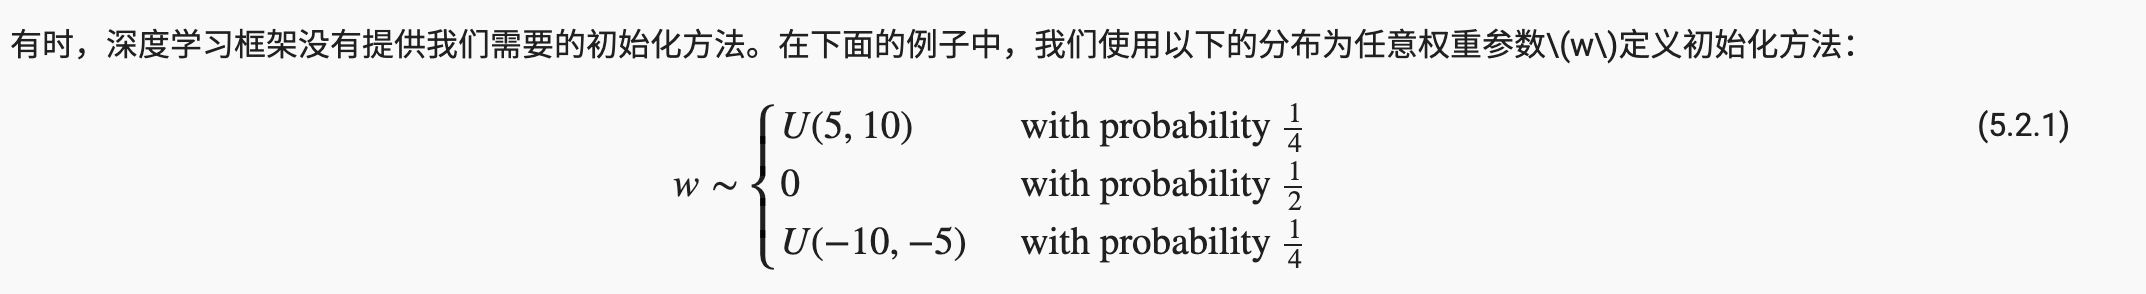

In [72]:
def my_init(m):
    if type(m) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[-0.0000, -8.0036,  5.1227,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  8.6989]], grad_fn=<SliceBackward>)

In [73]:
# 我们可以直接设置参数。

net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000, -7.0036,  6.1227,  1.0000])

## 参数绑定
有时我们希望在多个层间共享参数（也就是参数是一样的）。让我们看看如何优雅地做这件事。在下面，我们定义一个稠密层，然后使用它的参数来设置另一个层的参数。

In [74]:
# 我们需要给共享层一个名称，以便可以引用它的参数。
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
net(X)
# 检查参数是否相同
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# 确保它们实际上是同一个对象，而不只是有相同的值。
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


这个例子表明第二层和第三层的参数是绑定的。它们不仅值相等，而且由相同的张量表示。因此，如果我们改变其中一个参数，另一个参数也会改变。你可能会想，当参数绑定时，梯度会发生什么情况？答案是由于模型参数包含梯度，因此在反向传播期间第二个隐藏层和第三个隐藏层的梯度会加在一起。

# 自定义层
深度学习成功背后的一个因素是，可以用创造性的方式组合广泛的层，从而设计出适用于各种任务的结构。例如，研究人员发明了专门用于处理图像、文本、序列数据和执行动态编程的层。早晚有一天，你会遇到或要自己**发明一个在深度学习框架中还不存在的层**。在这些情况下，你必须构建自定义层。在本节中，我们将向你展示如何操作。

## 不带参数的层

要构建它，我们只需继承基础层类并实现正向传播功能。

In [75]:
import torch
import torch.nn.functional as F
from torch import nn


class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()

In [76]:
# 我们通过向其提供一些数据来验证该层是否按预期工作。
layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

In [77]:
# 将层作为组件合并到构建更复杂的模型中
net = nn.Sequential(nn.Linear(8, 128), CenteredLayer())

In [78]:
Y = net(torch.rand(4, 8))
Y.mean()

tensor(9.3132e-10, grad_fn=<MeanBackward0>)

### 带参数的层
既然我们知道了如何定义简单的层，那么让我们继续定义具有参数的层，这些参数可以通过训练进行调整。我们可以使用内置函数来创建参数，这些函数提供一些基本的管理功能。比如管理访问、初始化、共享、保存和加载模型参数。这样做的好处之一是，我们不需要为每个自定义层编写自定义序列化程序。

现在，让我们实现自定义版本的全连接层。回想一下，该层需要两个参数，一个用于表示权重，另一个用于表示偏置项。在此实现中，我们使用ReLU作为激活函数。该层需要输入参数：in_units和units，分别表示输入和输出的数量。

In [79]:
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units,))
        
    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

In [82]:
# 实例化MyLinear类并访问其模型参数
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[ 2.5713,  0.7720,  2.2073],
        [-1.3729, -1.2860, -1.3037],
        [-0.0571, -0.4051,  0.3446],
        [ 1.2466,  0.2162, -0.8080],
        [ 0.1453, -1.9548, -2.0659]], requires_grad=True)

In [81]:
# 我们可以使用自定义层直接执行正向传播计算。
linear(torch.rand(2, 5))

tensor([[0.0000, 1.5433, 0.0611],
        [0.2331, 1.5313, 0.0000]])

In [83]:
# 使用自定义层构建模型。我们可以像使用内置的全连接层一样使用自定义层。
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[6.1950],
        [3.2081]])